# Sentiment Analysis on Social Media Posts with LSTM

Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bz2
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.corpus import stopwords
from textblob import TextBlob
import nltk
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.metrics import classification_report


Reading the dataset

In [3]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    labels = labels[:int(len(labels)*0.01)]
    texts = texts[:int(len(texts)*0.01)]
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('test.ft.txt.bz2')


In [4]:
train_df=pd.DataFrame(zip(train_texts,train_labels),columns=['text','label'])
print(train_df.head())
test_df=pd.DataFrame(zip(test_texts,test_labels),columns=['text','label'])
print(test_df.head())

                                                text  label
0  Stuning even for the non-gamer: This sound tra...      1
1  The best soundtrack ever to anything.: I'm rea...      1
2  Amazing!: This soundtrack is my favorite music...      1
3  Excellent Soundtrack: I truly like this soundt...      1
4  Remember, Pull Your Jaw Off The Floor After He...      1
                                                text  label
0  Great CD: My lovely Pat has one of the GREAT v...      1
1  One of the best game music soundtracks - for a...      1
2  Batteries died within a year ...: I bought thi...      0
3  works fine, but Maha Energy is better: Check o...      1
4  Great for the non-audiophile: Reviewed quite a...      1


A sample a review 

In [5]:
print(train_df.text[5])

an absolute masterpiece: I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs and quite a few songs (I haven't an exact count), all of which are heart-rendering and impressively remarkable, this soundtrack is one I assure you you will not forget. It has everything for every listener -- from fast-paced and energetic (Dancing the Tokage or Termina Home), to slower and more haunting (Dragon God), to purely beautifully composed (Time's Scar), to even some fantastic vocals (Radical Dreamers).This is one of the best videogame soundtracks out there, and surely Mitsuda's best ever. ^_^


Data Overview

In [6]:
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    36000 non-null  object
 1   label   36000 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 422.0+ KB
None


In [7]:
print(test_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 47.0+ KB
None


Check for Missing Values

In [8]:
print(train_df.isnull().sum())


text     0
label    0
dtype: int64


In [9]:
print(test_df.isnull().sum())


text     0
label    0
dtype: int64


Check for the shap of the data

In [10]:
train_df.shape

(36000, 2)

In [11]:
test_df.shape

(4000, 2)

Distribution of Labels

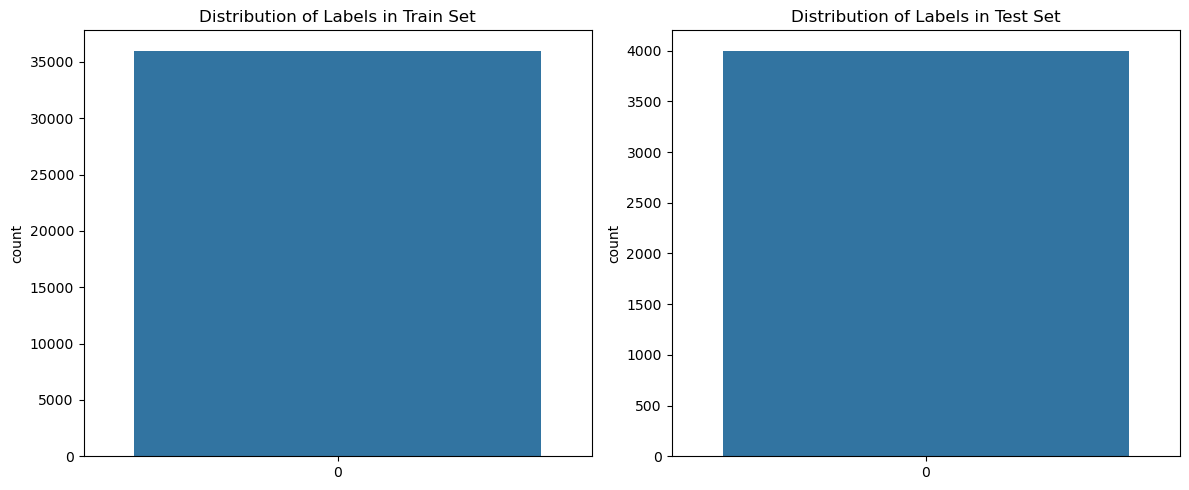

In [12]:

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.countplot(train_df['label'])
plt.title('Distribution of Labels in Train Set')

plt.subplot(1,2,2)
sns.countplot(test_df['label'])
plt.title('Distribution of Labels in Test Set')
plt.tight_layout()
plt.show()


Analyze Text Length

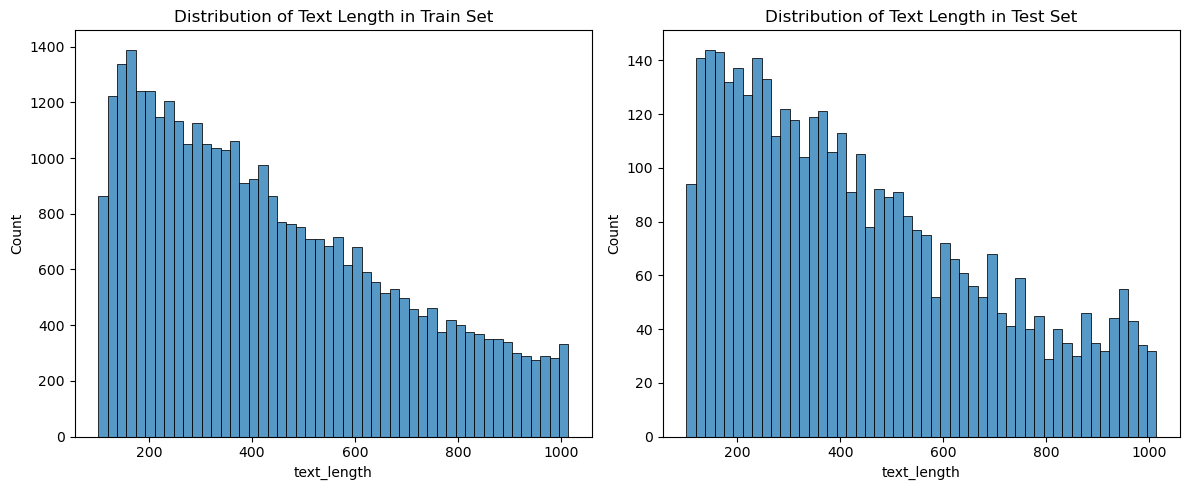

In [13]:
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.histplot(train_df['text_length'], bins=50)
plt.title('Distribution of Text Length in Train Set')

plt.subplot(1,2,2)
sns.histplot(test_df['text_length'], bins=50)
plt.title('Distribution of Text Length in Test Set')
plt.tight_layout()
plt.show()


Word Cloud for Most Common Words

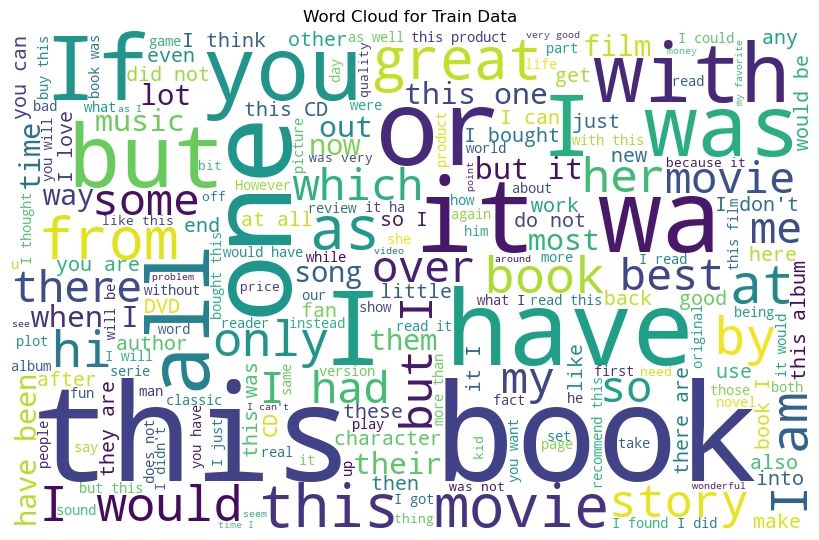

In [14]:
# Generate word cloud for train data
wordcloud_train = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                stopwords = set(['the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that']),
                min_font_size = 10).generate(' '.join(train_df['text']))

# Plot word cloud for train data
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_train)
plt.axis("off")
plt.title("Word Cloud for Train Data")
plt.tight_layout(pad=0)
plt.show()


Which group of words frequently appear together

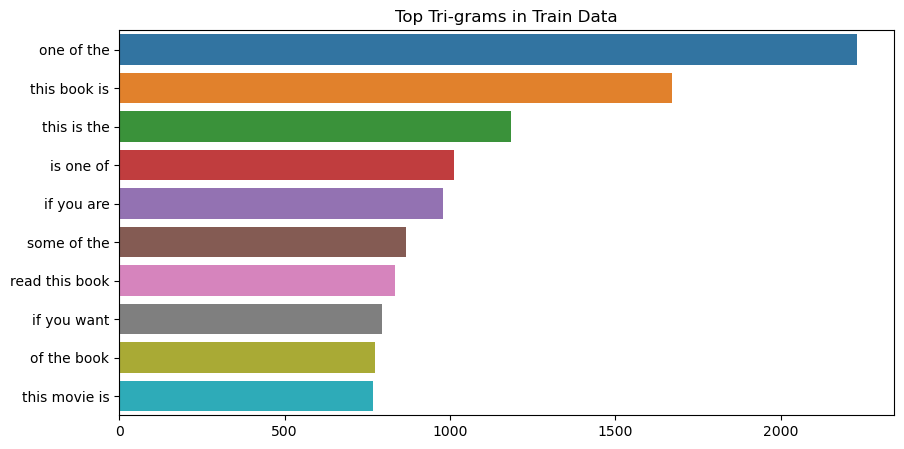

In [15]:
# Top tri-grams for train data
def top_ngrams(text, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

# Plot top tri-grams for train data
top_trigrams = top_ngrams(train_df['text'], 3)
x,y = map(list, zip(*top_trigrams))
plt.figure(figsize=(10,5))
sns.barplot(x=y, y=x)
plt.title('Top Tri-grams in Train Data')
plt.show()


Average Word Length

C:\Users\Khadi\AppData\Local\Temp\ipykernel_4056\1269939321.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['average_word_length']).set_title('Average Word Length Distribution in Train Set');


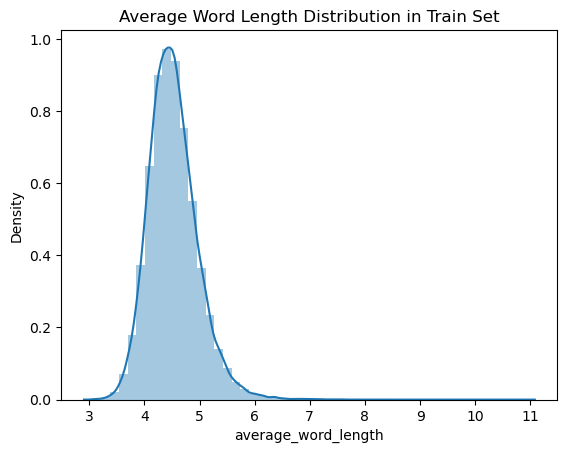

In [16]:
train_df['average_word_length'] = train_df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
sns.distplot(train_df['average_word_length']).set_title('Average Word Length Distribution in Train Set');


Common and Rare Words

In [17]:

all_words = ' '.join(train_df['text']).split()
freq = Counter(all_words)
print("Most Common words: ", freq.most_common(10))
print("Most Rare words: ", freq.most_common()[-10:])


Most Common words:  [('the', 124279), ('and', 75050), ('a', 68580), ('I', 68008), ('to', 66986), ('of', 59562), ('is', 50504), ('this', 39649), ('it', 37592), ('in', 32098)]
Most Rare words:  [('Items:', 1), ('It"s', 1), ('grab.serious', 1), ('tweesin.', 1), ('tweezers:', 1), ('weak?', 1), ('purses.', 1), ('regular-sized', 1), ('Tweezer:', 1), ("'green'", 1)]


Distribution of Stopwords

C:\Users\Khadi\AppData\Local\Temp\ipykernel_4056\3970043779.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['stopword_count']).set_title('Stopword Count Distribution in Train Set');


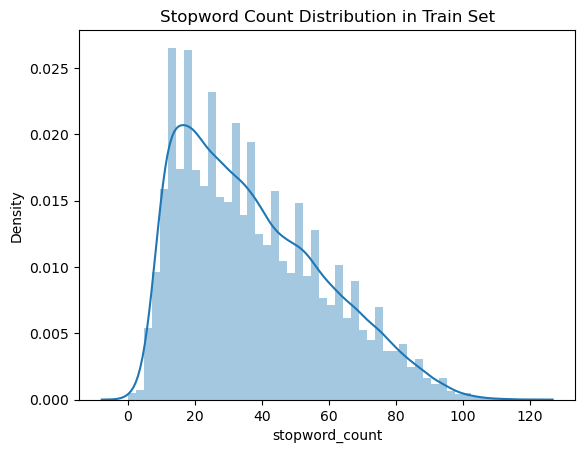

In [18]:

stop_words = set(stopwords.words('english'))
train_df['stopword_count'] = train_df['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
sns.distplot(train_df['stopword_count']).set_title('Stopword Count Distribution in Train Set');


Sentiment Analysis (if labels are not sentiments)

In [19]:

train_df['polarity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['subjectivity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
train_df.head()


,text,label,text_length,average_word_length,stopword_count,polarity,subjectivity
0,Stuning even for the non-gamer: This sound tra...,1,426,4.337500,36,-0.021875,0.550000
1,The best soundtrack ever to anything.: I'm rea...,1,509,4.257732,48,0.261111,0.517460
2,Amazing!: This soundtrack is my favorite music...,1,760,4.899225,53,0.274691,0.545988
3,Excellent Soundtrack: I truly like this soundt...,1,743,5.305085,44,0.272727,0.463636
4,"Remember, Pull Your Jaw Off The Floor After He...",1,481,4.540230,37,0.324802,0.520317


Distribution of Part-of-Speech Tags

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Khadi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


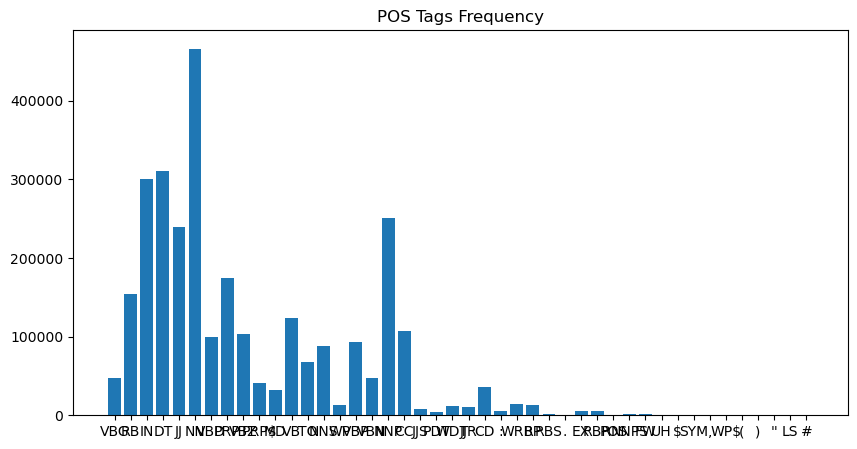

In [20]:

nltk.download('averaged_perceptron_tagger')
pos_tags = nltk.pos_tag(all_words)
tags_freq = Counter(tag for word, tag in pos_tags)
plt.figure(figsize=(10, 5))
plt.bar(tags_freq.keys(), tags_freq.values())
plt.title('POS Tags Frequency')
plt.show()


Correlation

C:\Users\Khadi\AppData\Local\Temp\ipykernel_4056\3151725941.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


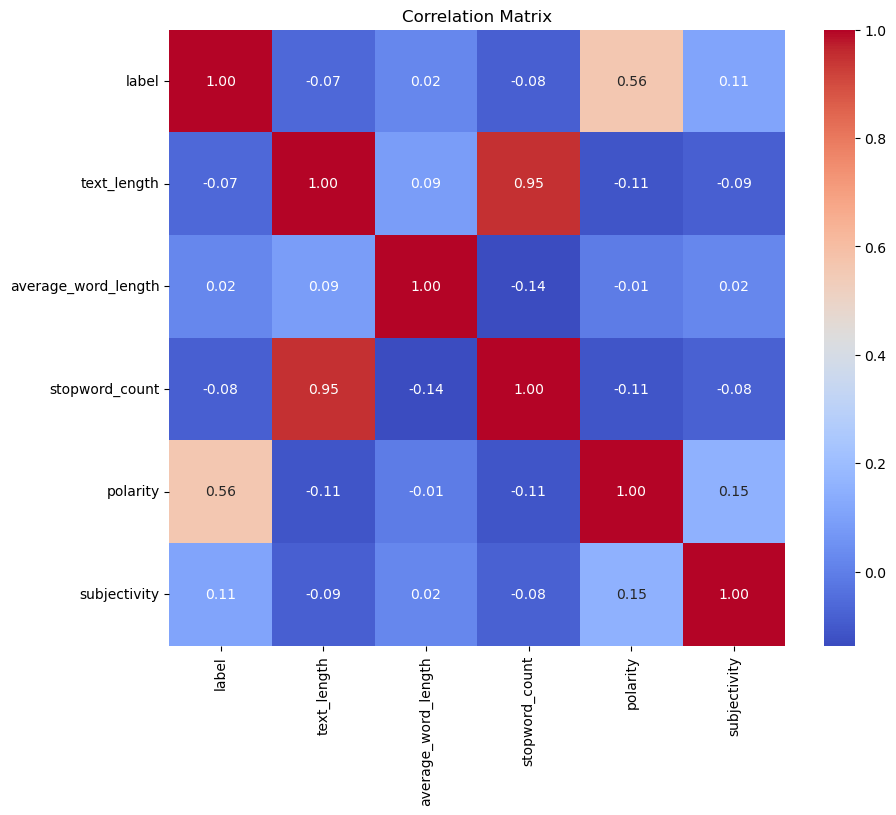

In [21]:
# Compute the correlation matrix
corr = train_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", cbar=True, square=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Identifying Outliers

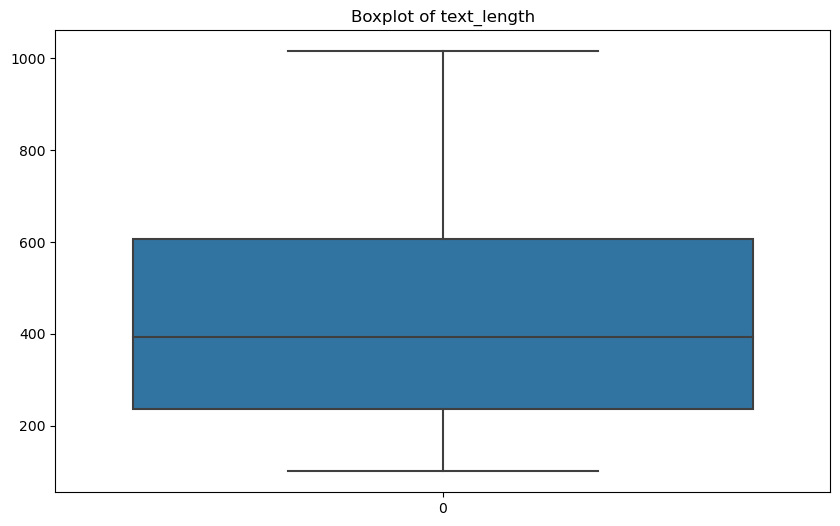

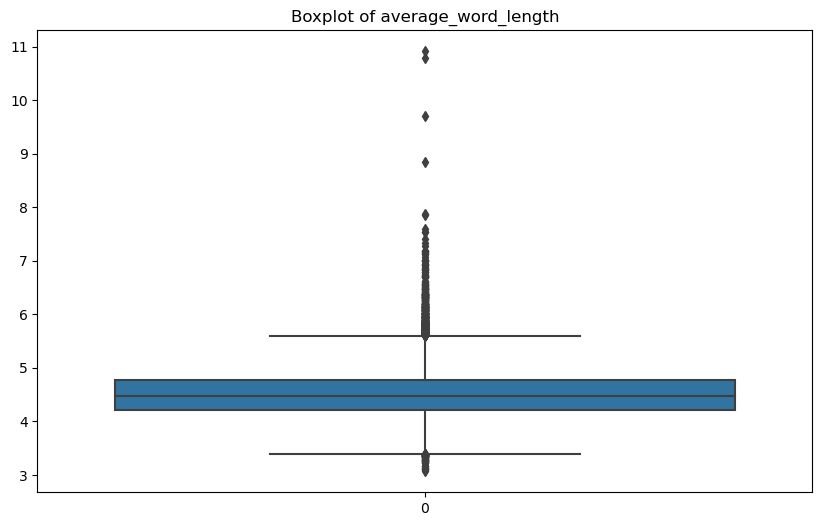

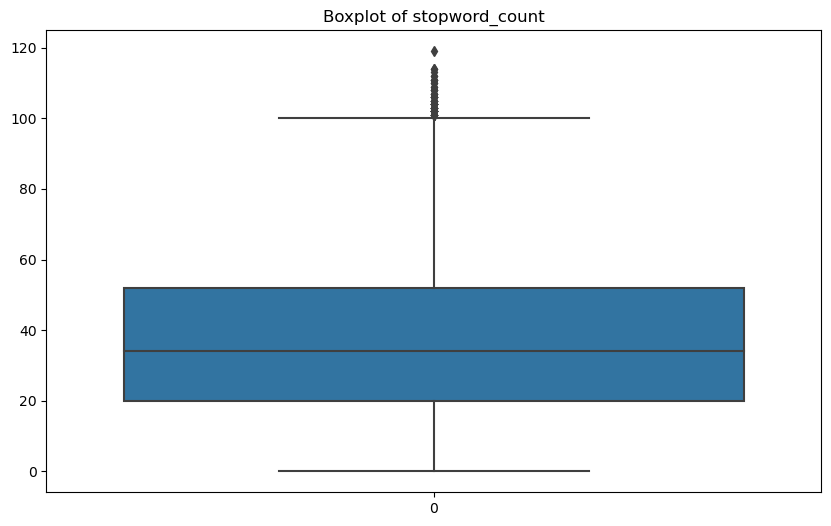

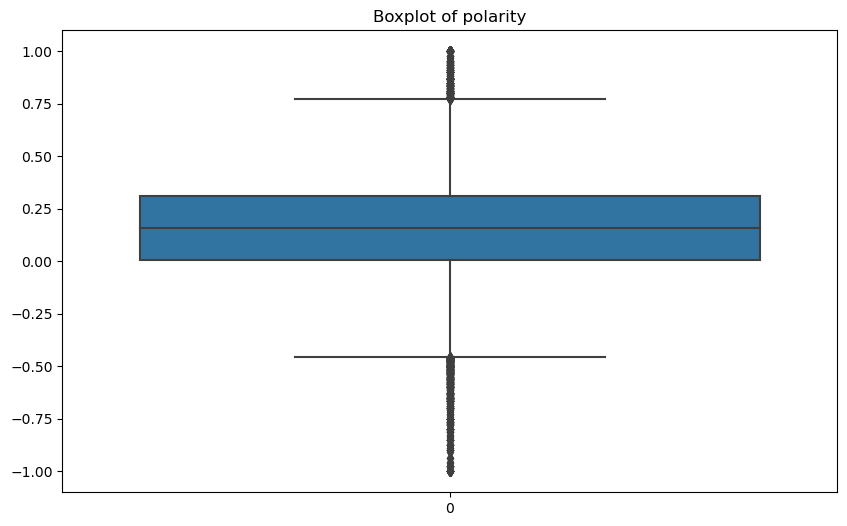

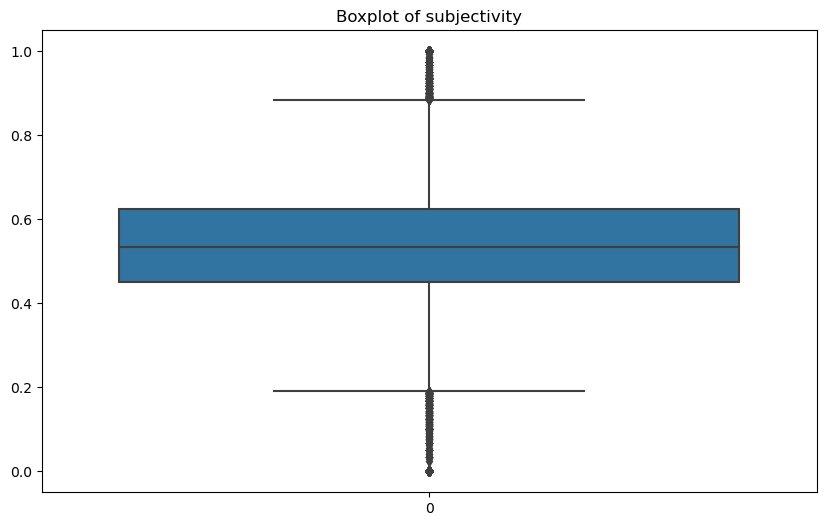

In [22]:
# Using boxplots to visualize outliers
for column in train_df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(train_df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


Preprocessing

Text Cleaning

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['text_cleaned'] = train_df['text'].apply(clean_text)
test_df['text_cleaned'] = test_df['text'].apply(clean_text)


Remove Stopwords

In [24]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered)

train_df['text_cleaned'] = train_df['text_cleaned'].apply(remove_stopwords)
test_df['text_cleaned'] = test_df['text_cleaned'].apply(remove_stopwords)


Lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train_df['text_lemmatized'] = train_df['text_cleaned'].apply(lemmatize_text)
test_df['text_lemmatized'] = test_df['text_cleaned'].apply(lemmatize_text)


Tokenization

In [26]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text_lemmatized'])


Convert Texts to Sequences and Padding

In [27]:

max_length = 100
train_sequences = tokenizer.texts_to_sequences(train_df['text_lemmatized'])
test_sequences = tokenizer.texts_to_sequences(test_df['text_lemmatized'])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')


Modeling

In [28]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])



In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [39]:


early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


history = model.fit(
    train_padded, 
    train_df['label'], 
    epochs=50, 
    validation_data=(test_padded, test_df['label']),
    callbacks=[early_stop]
)


Epoch 1/50
1125/1125 [==============================] - 169s 150ms/step - loss: 0.6886 - accuracy: 0.5128 - val_loss: 0.7000 - val_accuracy: 0.4900
Epoch 2/50
1125/1125 [==============================] - 175s 155ms/step - loss: 0.6802 - accuracy: 0.5183 - val_loss: 0.7108 - val_accuracy: 0.5117
Epoch 3/50
1125/1125 [==============================] - 185s 164ms/step - loss: 0.6685 - accuracy: 0.5359 - val_loss: 0.6938 - val_accuracy: 0.5123
Epoch 4/50
1125/1125 [==============================] - 190s 169ms/step - loss: 0.6545 - accuracy: 0.5486 - val_loss: 0.7438 - val_accuracy: 0.5140
Epoch 5/50
1125/1125 [==============================] - 197s 175ms/step - loss: 0.6369 - accuracy: 0.5655 - val_loss: 0.7651 - val_accuracy: 0.5200
Epoch 6/50
1125/1125 [==============================] - 256s 227ms/step - loss: 0.6254 - accuracy: 0.5811 - val_loss: 0.7905 - val_accuracy: 0.5153
Epoch 7/50
1125/1125 [==============================] - 333s 296ms/step - loss: 0.6033 - accuracy: 0.6170 - val_

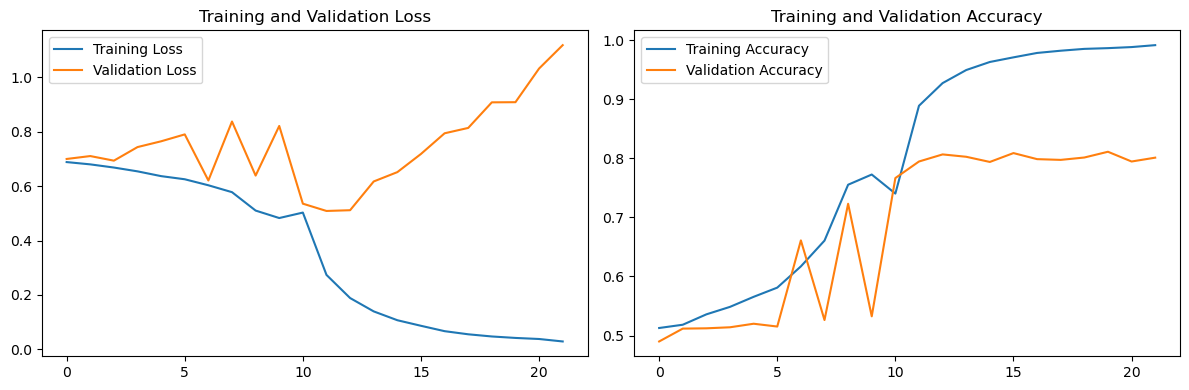

In [40]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


Model Prediction

In [41]:
y_pred_probs = model.predict(test_padded)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]


125/125 [==============================] - 8s 62ms/step


Evaluation using Metrics

In [42]:

# Metrics calculation
accuracy = accuracy_score(test_df['label'], y_pred)
precision = precision_score(test_df['label'], y_pred)
recall = recall_score(test_df['label'], y_pred)
f1 = f1_score(test_df['label'], y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.7945
Precision: 0.7920
Recall: 0.8121
F1 Score: 0.8019


In [43]:
report = classification_report(test_df['label'], y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1951
           1       0.79      0.81      0.80      2049

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



Visualization using Confusion Matrix

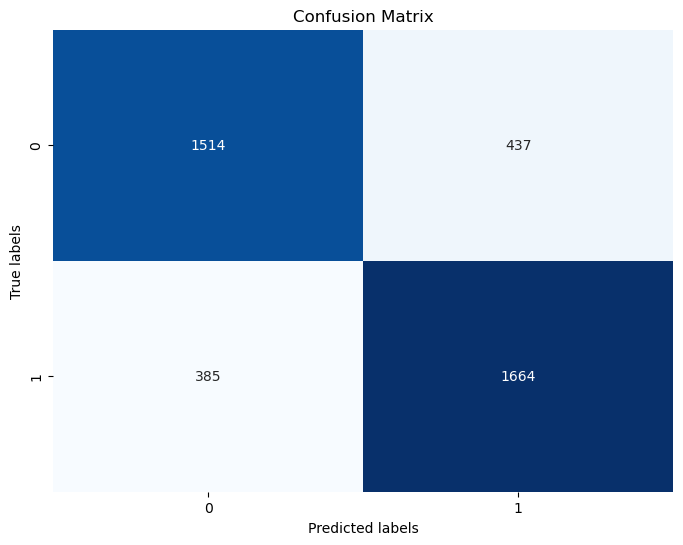

In [44]:
# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [45]:
model.save("sentimentmodel.h5")

In [46]:
loaded_model = load_model("sentimentmodel.h5")

In [47]:
def preprocess_user_input(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

def predict_sentiment():
    user_text = input("Enter the text for sentiment analysis: ")
    processed_input = preprocess_user_input(user_text)
    prediction = loaded_model.predict(processed_input)
    sentiment = "Positive" if np.argmax(prediction) > 0.5 else "Negative"
    print(f"The text sentiment is: {sentiment}")

predict_sentiment()


Enter the text for sentiment analysis: an absolute masterpiece: I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs and quite a few songs (I haven't an exact count), all of which are heart-rendering and impressively remarkable, this soundtrack is one I assure you you will not forget. It has everything for every listener -- from fast-paced and energetic (Dancing the Tokage or Termina Home), to slower and more haunting (Dragon God), to purely beautifully composed (Time's Scar), to even some fantastic vocals (Radical Dreamers).This is one of the best videogame soundtracks out there, and surely Mitsuda's best ever. 
1/1 [==============================] - 1s 729ms/step
The text sentiment is: Negative
